<a href="https://colab.research.google.com/github/jainilparikh/MusicStyleTransfer/blob/main/SpectrogramWithVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## What we can conclude from this file is that VGG is not suitable for usic style transfer as the conv filters are 3x3 which is not suitable for a 1D Signal(Music)

import tensorflow as tf
import numpy as np
import skimage
import os
from skimage import io
import scipy.io.wavfile
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install librosa --upgrade
!pip install pydub
!apt-get install ffmpeg
!pip install pygobject

     |████████████████████████████████| 184kB 10.7MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=501478744632b79eaaef856f2614eb8270e1d4f5b9248f82f47c9af81f2e740a
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [ ]:
import librosa
import cv2
import scipy
import librosa.display


def loadMusic(path , songNumber):
  x, sr = librosa.load(path, sr=44100)
  X = librosa.stft(x)
  spectrogram_librosa_db = librosa.power_to_db(X, ref=np.max)
  librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time')
  plt.title('Reference power spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()
  plt.show()
  val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
  maxVal = val.max()
  val = val / maxVal;
  print(val)
  #val = np.rint(val).astype(np.int16)
  print(val.min())
  print(val.max())
  scipy.io.wavfile.write('/content/song' + str(songNumber) + '.wav',44100,val)


  X = [spectrogram_librosa_db , spectrogram_librosa_db , spectrogram_librosa_db]
  X = np.array(X)
  print(X.shape)
  return np.reshape(X , (X.shape[1] , X.shape[2] , 3))

In [ ]:
## Checking Sampling Rate of the music Files.

from pydub.utils import mediainfo
info = mediainfo("/content/drive/My Drive/Nokia/mp3 data/data/wonderwall.mp3")
print(info['sample_rate'])
info = mediainfo("/content/drive/My Drive/Nokia/mp3 data/data/gettysburg.mp3")
print(info['sample_rate'])

44100
44100


/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


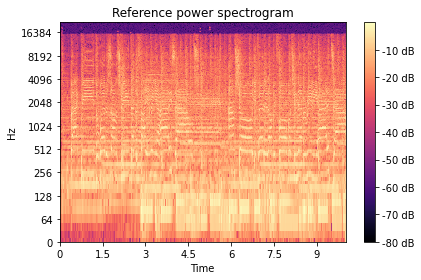

[-0.00896753 -0.0075603  -0.00513871 ...  0.05004417  0.07121269
  0.0941544 ]
-0.96950024
1.0
(3, 1025, 862)


/usr/local/lib/python3.6/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


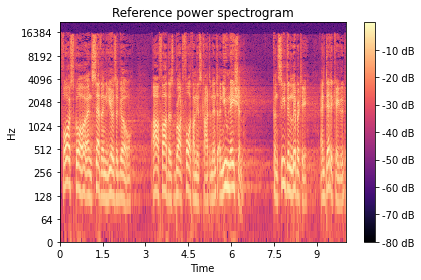

[0.00038735 0.00053384 0.00077678 ... 0.01355466 0.01371168 0.01188886]
-1.1127461
1.0
(3, 1025, 862)


In [ ]:
styleMusic = loadMusic("/content/drive/My Drive/Nokia/mp3 data/data/wonderwall.mp3",1)
contentMusic = loadMusic("/content/drive/My Drive/Nokia/mp3 data/data/gettysburg.mp3",2)

In [ ]:
def get_image(X):
    w=512
    h=512
   
    image = tf.keras.applications.vgg19.preprocess_input(tf.keras.preprocessing.image.img_to_array(X))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image , axis = 0)
    return image
def imgshow(image):
    image[:,:,0]  *=64/255.0
    image[:,:,1] *=128/255.0
    image[:,:,2] *=192/255.0
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8')
    img=np.squeeze(image)
    plt.figure(figsize = (50,10))
    plt.imshow(img, interpolation='nearest')
def imshowImage(image):
  image[:,:,0]  *=64/255.0
  image[:,:,1] *=128/255.0
  image[:,:,2] *=192/255.0
  image = image[:,:,::-1]
  image = np.clip(image,0,255).astype('uint8')
  img=np.squeeze(image)
  return img
#styleImage = get_image("/content/style.jpg")
#contentImage = get_image("/content/content.jpg")
#imgshow(styleImage)

styleMusicImage = get_image(styleMusic);
contentMusicImage = get_image(contentMusic);

In [ ]:
def gramMatrix(inputImage):
  channels=int(inputImage.shape[-1])
  a=tf.reshape(inputImage,[-1,channels])
  n=tf.shape(a)[0]
  gram=tf.matmul(a,a,transpose_a=True)
  return(gram/tf.cast(n,tf.float32))

In [ ]:
def styleLoss(model,inputImage,generated):
  error = 0
  for styleModels in model:
    styleVal = styleModels(inputImage);
    generatedVal = styleModels(generated)
    val = tf.reduce_mean((gramMatrix(styleVal) - gramMatrix(generatedVal))**2);
    error = error + val*1/len(model);
  return error;

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
baseModel = VGG19(weights='imagenet',include_top=False,pooling='Max');
baseModel.trainable = False;
contentImageLayers = ['block5_conv2']
styleImageLayers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
baseModel.get_layer(contentImageLayers[0])
print(baseModel.input)

80142336/80134624 [==============================] - 1s 0us/step
Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


In [ ]:
contentModel = Model(inputs = baseModel.input,outputs = baseModel.get_layer(contentImageLayers[0]).output) 

In [ ]:
styleModel = [Model(inputs = baseModel.input , outputs = baseModel.get_layer(Layer).output) for Layer in styleImageLayers]

In [ ]:
def customLoss(model,inputImage,outputImage):
  val = tf.reduce_mean((model(inputImage) - model(outputImage))**2)
  return val;

In [ ]:
def runFunction(contentImage,styleImage):
  ## Calculate loss for content image
  ## Calculate loss for style image
  ## update the initial image by the error from the losses calculated
  ## repeat the process
  contentGenerated = tf.Variable(contentImage,dtype = tf.float32);
  print(contentGenerated.shape)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1)
  maxImage = contentGenerated;
  maxCost = 1e12

  ## Weighted Loss calcualtion
  for i in range(0,10):  ####    Train till 500 steps
    print('Iteration : ' + str(i))
    with tf.GradientTape() as tape:
      print(contentGenerated.shape)
      contentLossVal = customLoss(contentModel,contentImage,contentGenerated)
      styleLossVal = styleLoss(styleModel , styleImage , contentGenerated)
      cost = contentLossVal * 40 + styleLossVal * 1000;
      gradient = tape.gradient(cost , contentGenerated);
      optimizer.apply_gradients([(gradient,contentGenerated)])
      print(cost)
      if(cost < maxCost):
        maxCost = cost;
        maxImage = contentGenerated.numpy();
  return maxImage,contentGenerated.numpy();

In [ ]:
musicImage , imgVal = runFunction(contentMusicImage , styleMusicImage)

(1, 1025, 862, 3)
Iteration : 0
(1, 1025, 862, 3)
tf.Tensor(2432896300000.0, shape=(), dtype=float32)
Iteration : 1
(1, 1025, 862, 3)
tf.Tensor(1048795100000.0, shape=(), dtype=float32)
Iteration : 2
(1, 1025, 862, 3)
tf.Tensor(623097300000.0, shape=(), dtype=float32)
Iteration : 3
(1, 1025, 862, 3)
tf.Tensor(519836000000.0, shape=(), dtype=float32)
Iteration : 4
(1, 1025, 862, 3)
tf.Tensor(435034260000.0, shape=(), dtype=float32)
Iteration : 5
(1, 1025, 862, 3)
tf.Tensor(346232100000.0, shape=(), dtype=float32)
Iteration : 6
(1, 1025, 862, 3)
tf.Tensor(319639700000.0, shape=(), dtype=float32)
Iteration : 7
(1, 1025, 862, 3)
tf.Tensor(262288830000.0, shape=(), dtype=float32)
Iteration : 8
(1, 1025, 862, 3)
tf.Tensor(215034800000.0, shape=(), dtype=float32)
Iteration : 9
(1, 1025, 862, 3)
tf.Tensor(192706800000.0, shape=(), dtype=float32)


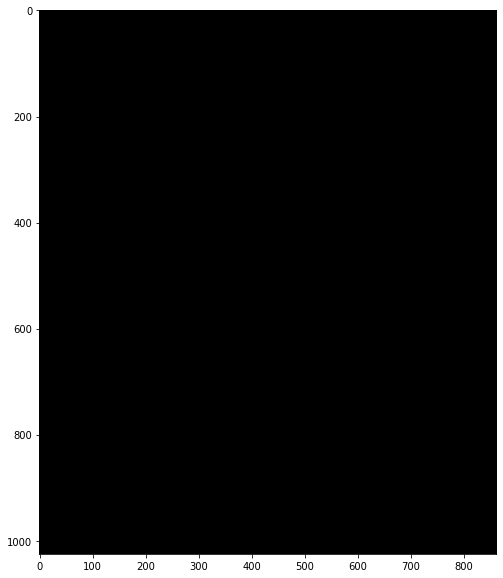

In [ ]:
imgshow(imgVal)

In [ ]:
X  = (musicImage[: , : , :, 0] + musicImage[: , : , : , 1] + musicImage[: , : , : ,2]) / 3;

In [ ]:
X = np.reshape(X , (X.shape[1] , X.shape[2]))

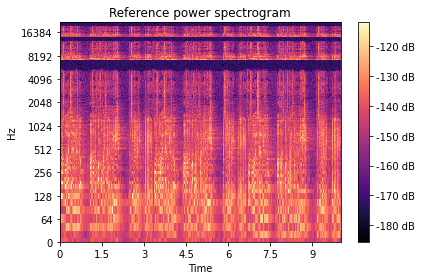

In [ ]:
librosa.display.specshow(X, sr=44100, y_axis='log', x_axis='time')
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
val = np.rint(val).astype(np.int16)
print(val.min())
print(val.max())
val = val / val.max()
scipy.io.wavfile.write('/content/songOutput.wav',44100,val)

-24
25
